In [1]:
%matplotlib inline
%load_ext autoreload

import pandas as pd
from processing_utils import *

### Data Pipeline Application

In [2]:
raw_dataset = pd.read_csv('./dataset/data.csv')

pruned_dataset = prune_dataset_lines(raw_dataset, remove_nan_lines=False, remove_nan_cols=True)
print("Raw dataset shape =", raw_dataset.shape, " Pruned dataset shape =", pruned_dataset.shape)

encoded_pruned_data = encode_smiles_column_of(pruned_dataset, 'count_encoding') # change to one_hot_encoding here
print("Encoded dataset shape =", encoded_pruned_data.shape)

X_train, y_train, X_val, y_val, X_test, y_test = return_required_data(
    encoded_pruned_data, 
    ['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'], 
    normalize=True
)

print("X_train shape =", X_train.shape)
print("y_train shape =", y_train.shape)
print("X_val shape =", X_val.shape)
print("y_val shape =", y_val.shape)
print("X_test shape =", X_test.shape)
print("y_test shape =", y_test.shape)

Raw dataset shape = (39926, 24)  Pruned dataset shape = (12865, 6)
Encoded dataset shape = (12865, 35)
X_train shape = (9005, 33)
y_train shape = (9005, 2)
X_val shape = (2702, 33)
y_val shape = (2702, 2)
X_test shape = (1158, 33)
y_test shape = (1158, 2)


### Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR = LR.fit(X_train, y_train)

y_pred_val = LR.predict(X_val)
y_pred_train = LR.predict(X_train)

print(LR.intercept_)
print("mse y_train, y_pred_train =", mean_squared_error(y_train, y_pred_train))
print("mse y_val, y_pred_val =", mean_squared_error(y_val, y_pred_val))

print("Sample prediction mse =", mean_squared_error(y_val[:10, :], LR.predict(X_val[:10, :])))
print("Actual Real target values : \n", y_val[:5, :])
print("Sample predicted vector : \n", LR.predict(X_val[:5, :]))

[4.06343295e-16 3.15038262e-16]
mse y_train, y_pred_train = 2.733692055295139e-06
mse y_val, y_pred_val = 0.0005395176161845391
Sample prediction mse = 0.00021530780328409167
Actual Real target values : 
 [[-2.08553055 -2.08020615]
 [-0.61242337 -0.61807893]
 [-0.75002236 -0.74752656]
 [-0.15626746 -0.15550055]
 [-1.48699455 -1.48758001]]
Sample predicted vector : 
 [[-2.06772498 -2.06248767]
 [-0.60020363 -0.60574707]
 [-0.75245421 -0.74998744]
 [-0.16870459 -0.16792953]
 [-1.48895904 -1.48949245]]


In [8]:
print("Cross validation error = ", cross_validation_of( LR, np.vstack((X_train, X_test)), np.vstack((y_train, y_test)) ))

Cross validation error =  0.0008075089494236521


{'fit_time': array([0.02963495, 0.0170269 , 0.03795791, 0.03686547, 0.0283587 ,
       0.03106523, 0.0263207 , 0.04643798, 0.02493858, 0.02569771]), 'score_time': array([0.00077295, 0.00178576, 0.00186586, 0.00289822, 0.0032084 ,
       0.0016706 , 0.00202608, 0.00183201, 0.00520444, 0.00185776]), 'test_r2': array([0.99989791, 0.99988959, 0.99989923, 0.99986621, 0.99989457,
       0.99988693, 0.99989726, 0.99988537, 0.99937579, 0.99346088]), 'test_neg_mean_squared_error': array([-1.00980453e-04, -1.11369936e-04, -9.70404017e-05, -1.47512800e-04,
       -1.04614959e-04, -1.15123160e-04, -1.01725572e-04, -1.10802044e-04,
       -5.97323510e-04, -6.58859666e-03])}


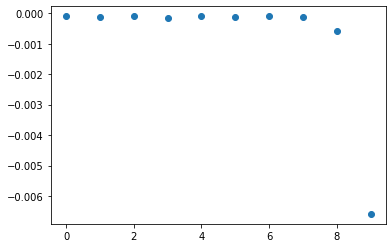

In [17]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
scores = cross_validate(LR, np.vstack((X_train, X_test)), np.vstack((y_train, y_test)), scoring=['r2', 'neg_mean_squared_error'], cv=10)
plt.scatter(range(10), scores['test_neg_mean_squared_error'])

### RBF Network Regression

In [12]:
# TODO : Use RBF.py to see performance.